# Fingerprint exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nglview

from opencadd.databases.klifs import setup_remote
from kissim.encoding import Fingerprint

In [3]:
# if using a Jupyter notebook, include:
#%matplotlib inline
plt.style.use("seaborn")
REMOTE = setup_remote()

In [4]:
HERE = Path(_dh[-1])
RESULTS = HERE / "../../results/"

## Plotting functions

In [5]:
def plot_boxplot(features, title, color, path_output=None):
    """
    Generate boxplot describing the feature distribution per feature name.

    Parameters
    ----------
    features : TODO
        TODO
    title : str
        Label name for type of fingerprint feature.
    color : str
        Color (matplotlib).
    path_output : pathlib.Path or str
        Path to output folder.

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot
        Boxplot axes.
    """

    axes = features.plot(
        figsize=(8.5, 6),
        kind="box",
        title=title,
        grid=False,
        boxprops=dict(color=color, linestyle="-", linewidth=1.5),
        flierprops=dict(
            linestyle="none",
            marker="o",
            markerfacecolor="none",
            markersize=3,
            markeredgecolor="grey",
        ),
        medianprops=dict(color="grey", linestyle="-", linewidth=1.5),
        whiskerprops=dict(color=color, linestyle="-", linewidth=1.5),
        capprops=dict(color=color, linestyle="-", linewidth=1.5),
        showfliers=True,
    )

    # https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib
    # axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')

    if path_output is not None:
        axes.get_figure().savefig(
            Path(path_output) / f"feature_distribution_boxplot_{features_type}.png",
            dpi=300,
            # bbox_inches='tight'
        )

    return axes

## Load fingerprints and structure metadata

In [6]:
with open(RESULTS / "fingerprints.json", "r") as f:
    json_string = f.read()
fingerprints = json.loads(json_string)
print(f"Number of fingerprints: {len(fingerprints)}")

Number of fingerprints: 4918


In [7]:
structure_klifs_ids = [fingerprint["structure_klifs_id"] for fingerprint in fingerprints]
#len(structure_klifs_ids)
#structure_klifs_ids[0]

In [8]:
structures = REMOTE.structures.all_structures()
structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]

In [9]:
structures.head()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,...,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,9869,6ccy,B,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTESRVLQNSRPFLTALKYSCFVME...,...,False,False,False,False,False,False,20.403700,65.346802,42.717800,<NA>
1,2544,3qkl,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,...,False,False,False,False,False,False,18.555599,60.174702,57.331100,<NA>
12,2545,3o96,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKIL_____NRVLQNSRPFLTALKYSCFVME...,...,False,False,False,False,False,False,19.065500,62.588402,53.232498,<NA>
18,11747,6s9w,B,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,...,False,True,False,True,True,False,20.360001,67.553398,58.518398,<NA>
21,10914,6hhj,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,...,False,True,False,True,True,False,20.439400,68.758400,59.098000,<NA>


## Prepare feature data

- Get feature values for all fingerprints
- Get feature values for example fingerprint

In [10]:
def features_by_type(fingerprints, feature_type):
    try:
        features = [fingerprint["values_dict"][feature_type] for fingerprint in fingerprints]
    except KeyError:
        features = [fingerprint["values_dict"]["spatial"][feature_type] for fingerprint in fingerprints]
    
    if feature_type == "moments":
        f = []
        for i in features:
            for key, values in i.items():
                f.append(values)
        features = pd.DataFrame(f, columns=["moment1", "moment2", "moment3"])
    else: 
        features = pd.DataFrame(features)
        if feature_type == "distances":
            # TODO @kissim reset subpocket order
            features = features[["center", "hinge_region", "dfg_region", "front_pocket"]]
        features = pd.concat([features[column_name].explode(column_name) for column_name, column in features.items()], axis=1)
    features = features.astype("float64")
    return features

In [11]:
def features_by_structure_klifs_id(fingerprints, structure_klifs_id):
    return [fingerprint for fingerprint in fingerprints if fingerprint["structure_klifs_id"] == 3835][0]

## Feature distributions

### Discrete features: Physicochemical features

In [12]:
features_p = features_by_type(fingerprints, "physicochemical")
features_p

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure
0,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333
1,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333
2,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000
4,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333
...,...,...,...,...,...,...,...,...
418025,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.542857
418026,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000
418027,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.565217
418028,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.578947


In [13]:
features_p["exposure.categories"] = features_p["exposure"].apply(lambda x: 1.0 if 0 <= x < 0.45 else (2.0 if 0.45 <= x < 0.55 else 3.0))
features_p.head()

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure,exposure.categories
0,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333,3.0
1,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333,3.0
2,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000,3.0
4,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333,3.0


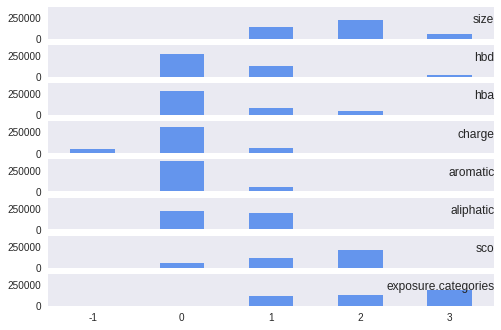

In [14]:
counts = pd.concat(
    [features_p[name].dropna().astype("int32").value_counts() for name, feature in features_p.items() if name != "exposure"],
    axis=1
)
counts = counts.fillna(0).astype("int32")
axes = counts.plot(kind="bar", subplots=True, grid=False, color="cornflowerblue", sharey=True, rot=0, legend=None, title=[""]*counts.shape[1])
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, counts.columns)];

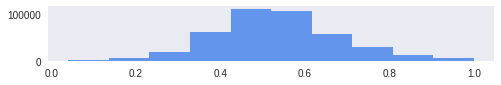

In [15]:
features_p["exposure"].hist(color="cornflowerblue", figsize=(8, 1), grid=False);

#### SCO(E24) vs. DFG conformation?

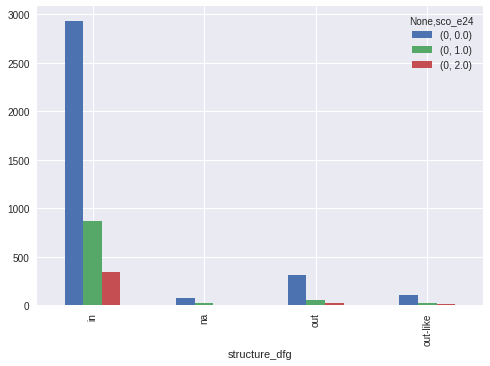

In [16]:
sco_e24 = [fingerprint["values_dict"]["physicochemical"]["sco"][24-1] for fingerprint in fingerprints]
sco_e24 = pd.DataFrame(
    {
        "structure_klifs_id": structures["structure.klifs_id"].to_list(), 
        "sco_e24": sco_e24, 
        "structure_dfg": structures["structure.dfg"].to_list()
    }
)
size = sco_e24.groupby(["sco_e24", "structure_dfg"]).size()
pd.DataFrame(size).unstack(level=0).plot(kind="bar");

### Continuous features: Distance features

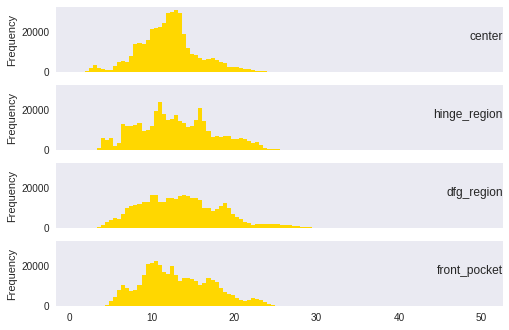

In [17]:
features_d = features_by_type(fingerprints, "distances")
axes = features_d.plot(kind="hist", subplots=True, grid=False, color="gold", sharey=True, rot=0, legend=None, title=[""]*features_d.shape[1], bins=100);
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, features_d.columns)];

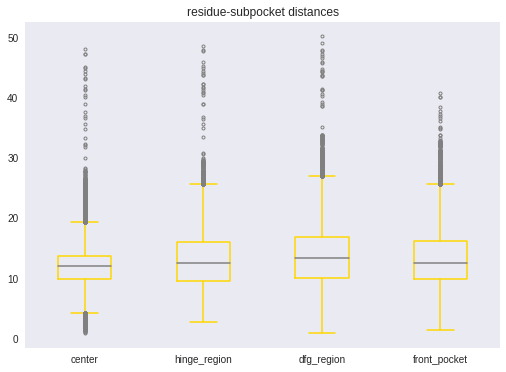

In [18]:
plot_boxplot(features_d, "residue-subpocket distances", "gold");

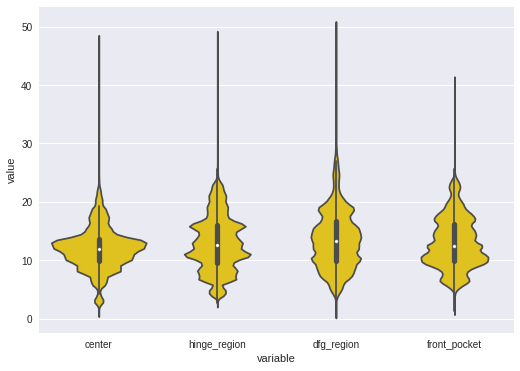

In [19]:
plt.figure(figsize=(8.5, 6))
sns.violinplot(x="variable", y="value", data=features_d.melt(), color="gold", rot=90);

#### Distance (DFG subpocket to E24) vs. DFG conformation

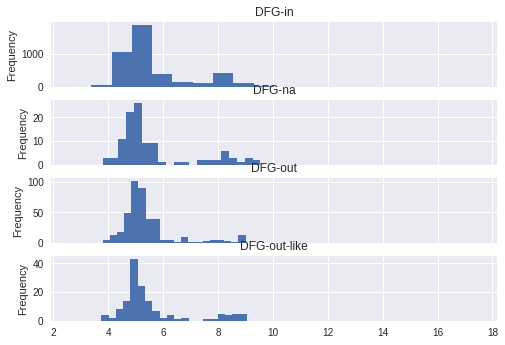

In [20]:
distances_dfg_e24 = [fingerprint["values_dict"]["spatial"]["distances"]["dfg_region"][24-1] for fingerprint in fingerprints]
distances_dfg_e24 = pd.DataFrame(
    {
        "structure_klifs_id": structures["structure.klifs_id"].to_list(), 
        "distance_dfg_e24": distances_dfg_e24, 
        "structure_dfg": structures["structure.dfg"].to_list()
    }
)
fig, axs = plt.subplots(4, sharex=True)
for i, (dfg, values) in enumerate(distances_dfg_e24[["structure_dfg", "distance_dfg_e24"]].groupby("structure_dfg")):
    values["distance_dfg_e24"].plot(kind="hist", bins=20, ax=axs[i], title=f"DFG-{dfg}");

In [21]:
pd.DataFrame(distances_dfg_e24[["structure_dfg", "distance_dfg_e24"]].groupby("structure_dfg"))

,0,1
0,in,structure_dfg distance_dfg_e24 0 ...
1,na,structure_dfg distance_dfg_e24 292 ...
2,out,structure_dfg distance_dfg_e24 2 ...
3,out-like,structure_dfg distance_dfg_e24 21 ...


### Continuous features: Moment features

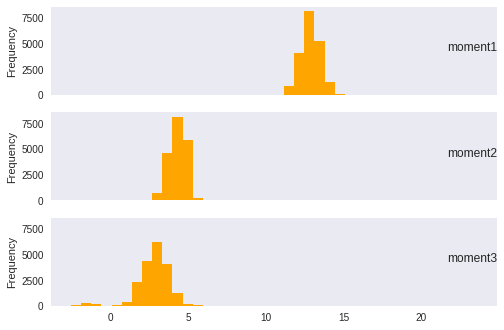

In [22]:
features_m = features_by_type(fingerprints, "moments")
axes = features_m.plot(kind="hist", subplots=True, grid=False, color="orange", sharey=True, rot=0, legend=None, title=[""]*features_m.shape[1], bins=40);
[ax.set_title(name, loc="right", pad=0, y=0.5) for ax, name in zip(axes, features_m.columns)];

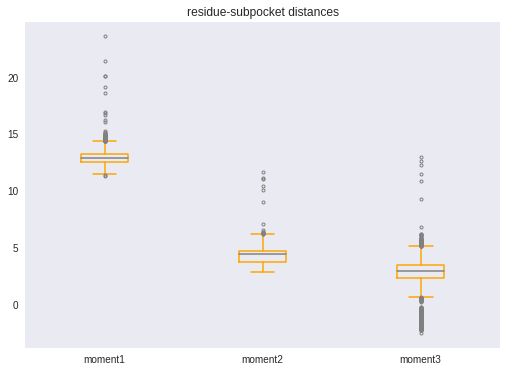

In [23]:
plot_boxplot(features_m, "residue-subpocket distances", "orange");

In [24]:
features = [fingerprint["values_dict"]["spatial"]["moments"] for fingerprint in fingerprints]
f = []
for i in features:
    for key, values in i.items():
        f.append([key] + values)
features = pd.DataFrame(f, columns=["subpocket", "moment1", "moment2", "moment3"]).reset_index()
features = features.melt(id_vars=["subpocket", "index"])
# TODO @kissim reset subpocket order
features = features.sort_values(["subpocket", "variable"])

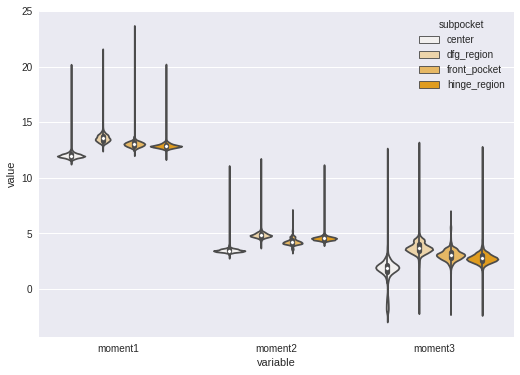

In [25]:
plt.figure(figsize=(8.5, 6))
axes = sns.violinplot(x="variable", y="value", hue="subpocket", data=features, color="orange", rot=90)

## Example fingerprint in 3D

In [26]:
#fingerprint = features_by_structure_klifs_id(fingerprints, 3835)
example_fingerprint = Fingerprint.from_structure_klifs_id(3835)
example_features = example_fingerprint.physicochemical
example_features.index = example_fingerprint.residue_ids
example_features

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure
50,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333
51,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333
52,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692
53,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000
54,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333
...,...,...,...,...,...,...,...,...
194,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.538462
195,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.358974
196,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.555556
197,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.468750


### Side chain orientation

In [27]:
value_to_color = {0.0: "blue", 1.0: "magenta", 2.0: "red"}
color_scheme_list = []
for residue_id, value in example_features.iterrows():
    try:
        color = value_to_color[value["sco"] ]
    except KeyError:
        color = "grey"
    color_scheme_list.append([color, str(residue_id)])

viewer = nglview.NGLWidget()
viewer._remote_call("setSize", target="Widget", args=["1000px", "600px"])
text = REMOTE.coordinates.to_text(3835, "complex", "pdb")
viewer.add_component(text, ext="pdb")
viewer.clear_representations()
color_scheme = nglview.color._ColorScheme(color_scheme_list, label="scheme_regions")
viewer.add_representation("cartoon", selection="protein", component=0, color="grey")
selection = " or ".join([str(i) for i in example_fingerprint.residue_ids])
viewer.add_representation("ball+stick", selection=selection, color=color_scheme)
viewer.display(gui=True)

ThemeManager()

NGLWidget(gui_style='ngl')

In [28]:
viewer.render_image(trim=True, transparent=True);

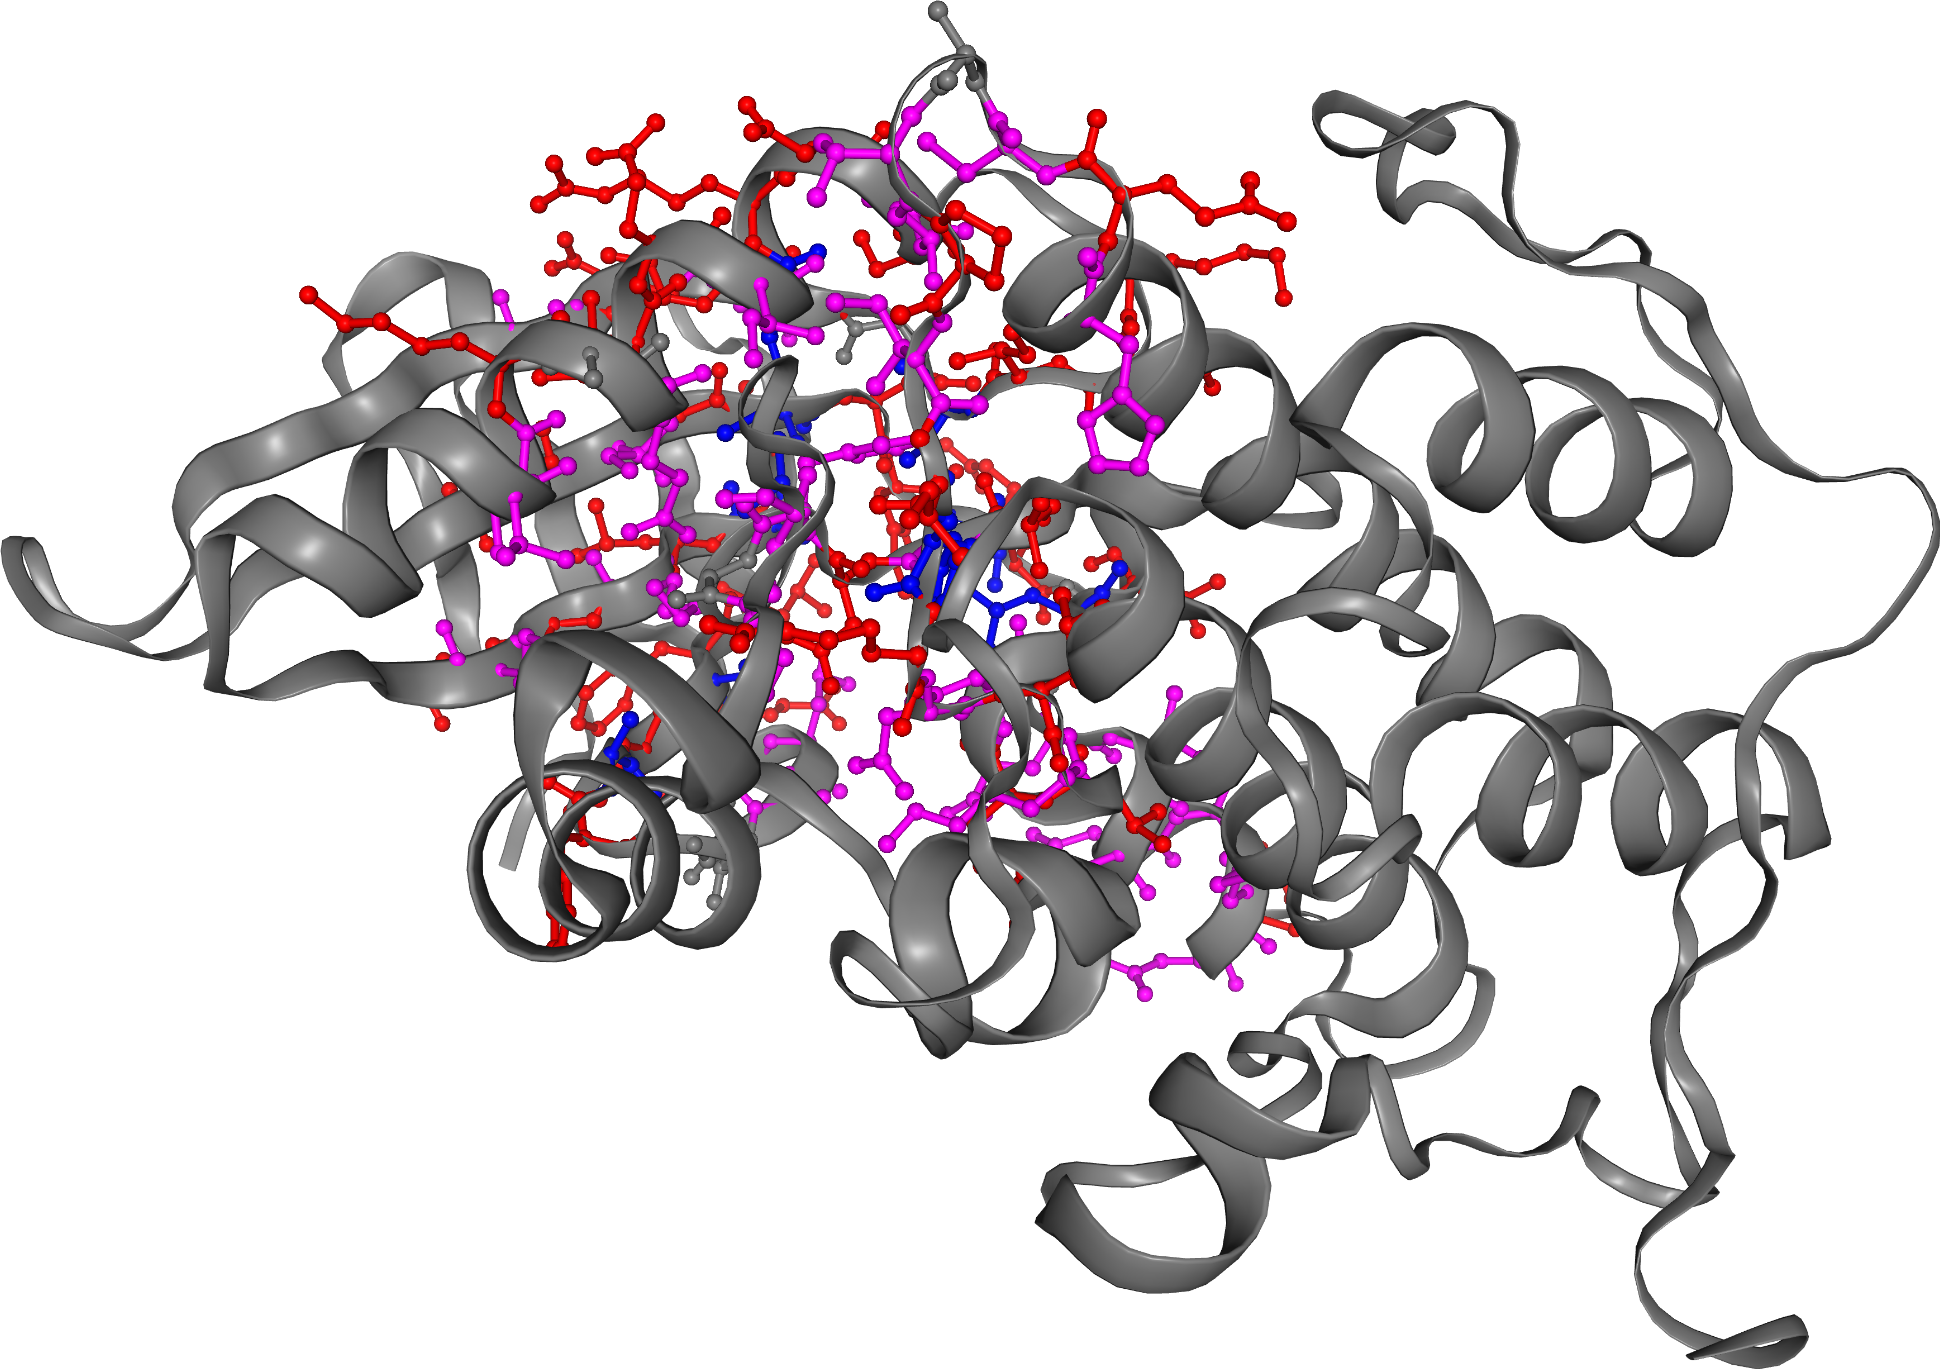

In [29]:
viewer._display_image()

### Solvent exposure

In [30]:
example_features["exposure.categories"] = example_features["exposure"].apply(lambda x: 1.0 if 0 <= x < 0.45 else (2.0 if 0.45 <= x < 0.55 else 3.0))
example_features

,size,hbd,hba,charge,aromatic,aliphatic,sco,exposure,exposure.categories
50,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.708333,3.0
51,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.583333,3.0
52,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.307692,1.0
53,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.600000,3.0
54,2.0,0.0,2.0,-1.0,0.0,0.0,NaN,0.833333,3.0
...,...,...,...,...,...,...,...,...,...
194,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,0.538462,2.0
195,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.358974,1.0
196,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.555556,3.0
197,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.468750,2.0


In [31]:
value_to_color = {1.0: "blue", 2.0: "magenta", 3.0: "red"}
color_scheme_list = []
for residue_id, value in example_features.iterrows():
    try:
        color = value_to_color[value["exposure.categories"] ]
    except KeyError:
        color = "grey"
    color_scheme_list.append([color, str(residue_id)])

viewer = nglview.NGLWidget()
viewer._remote_call("setSize", target="Widget", args=["1000px", "600px"])
text = REMOTE.coordinates.to_text(3835, "complex", "pdb")
viewer.add_component(text, ext="pdb")
viewer.clear_representations()
color_scheme = nglview.color._ColorScheme(color_scheme_list, label="scheme_regions")
viewer.add_representation("cartoon", selection="protein", component=0, color=color_scheme)
selection = " or ".join([str(i) for i in example_fingerprint.residue_ids])
viewer.add_representation("ball+stick", selection=selection, color=color_scheme)
#viewer.add_representation("surface", selection=selection, component=0, opacity=0.05, color="green")
viewer.display(gui=True)

NGLWidget(gui_style='ngl')

In [32]:
viewer.render_image(trim=True, transparent=True);

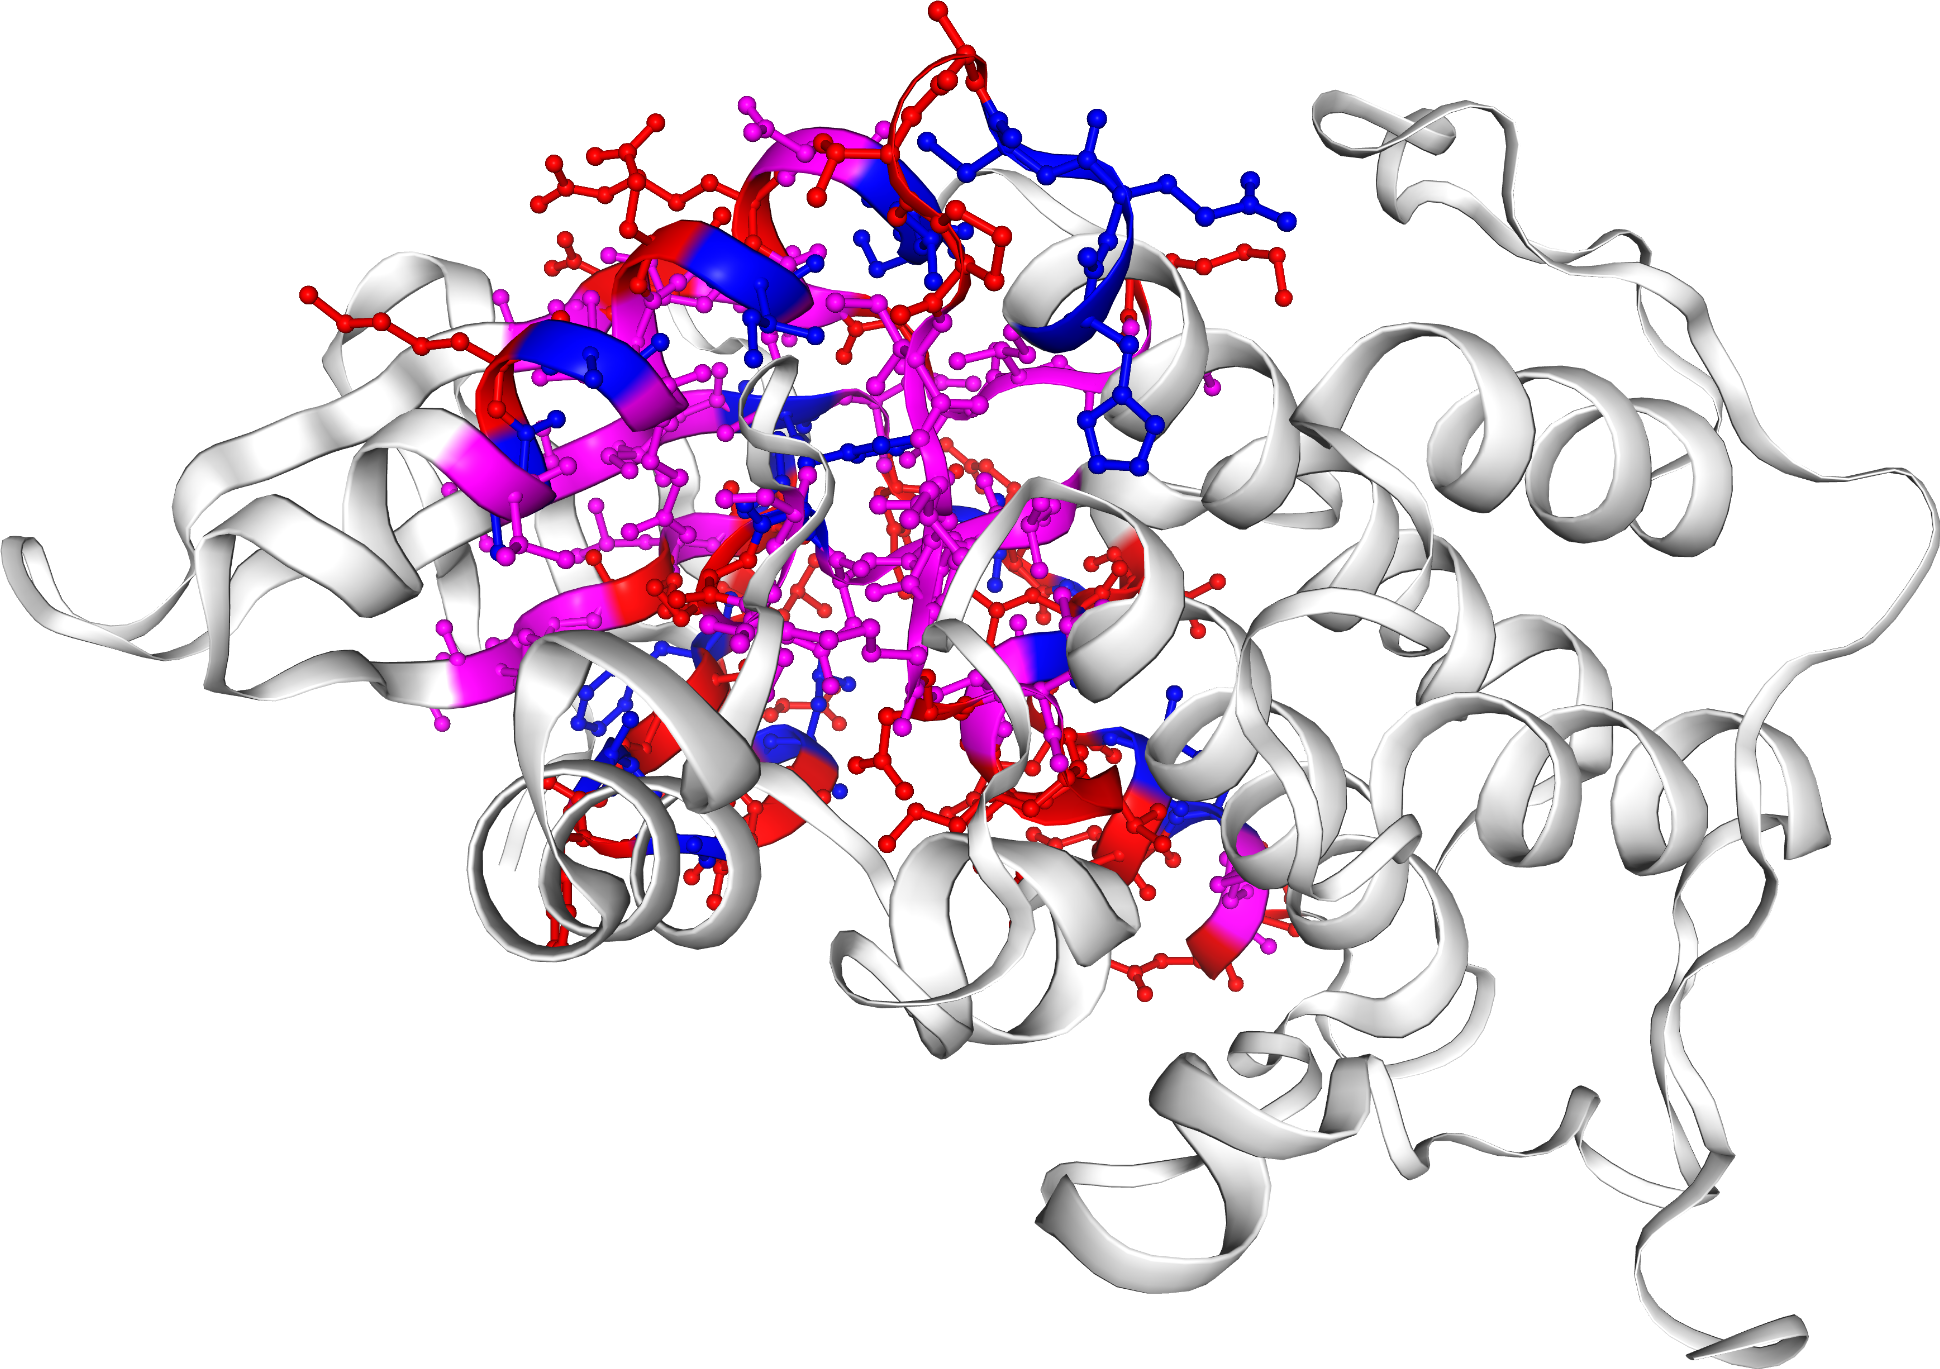

In [33]:
viewer._display_image()